In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [30]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 2s 53ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 2/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 3/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 4/100
13/13 [==============================] - 0s 39ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 5/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 6/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 7/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 8/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 9/100
13/13 [==============================] - 1s 62ms/step - loss: 0.0535 - val_loss: 0.1426
Epoch 10/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0535 - val_loss: 0.1426

In [32]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 [==============================] - 0s 6ms/step


In [33]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 33ms/step
[[19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]
 [19231.7]]


In [34]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 62280.421339031396
MAPE trên tập test là: 74.4898643170375 %
MSLE trên tập test là: 1.9729987280497472


In [35]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

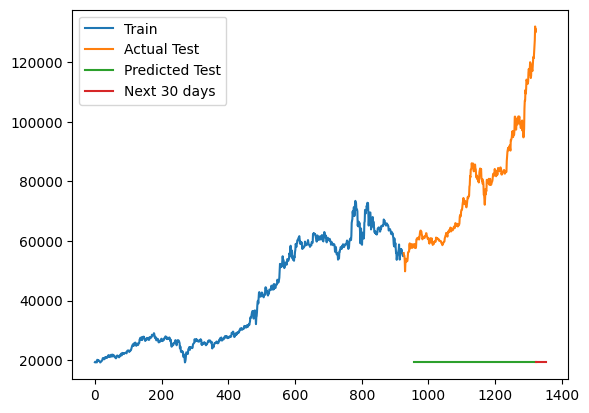

In [36]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 8/2)

In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [38]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [39]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
15/15 [==============================] - 2s 48ms/step - loss: 0.0221 - val_loss: 0.0111
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 0.0021 - val_loss: 9.2035e-04
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 7.4626e-04 - val_loss: 2.4267e-04
Epoch 4/100
15/15 [==============================] - 1s 33ms/step - loss: 5.5433e-04 - val_loss: 2.3668e-04
Epoch 5/100
15/15 [==============================] - 1s 35ms/step - loss: 5.4137e-04 - val_loss: 2.4615e-04
Epoch 6/100
15/15 [==============================] - 0s 33ms/step - loss: 5.2496e-04 - val_loss: 1.9064e-04
Epoch 7/100
15/15 [==============================] - 1s 36ms/step - loss: 5.1830e-04 - val_loss: 1.7988e-04
Epoch 8/100
15/15 [==============================] - 1s 34ms/step - loss: 5.0071e-04 - val_loss: 1.7822e-04
Epoch 9/100
15/15 [==============================] - 1s 35ms/step - loss: 4.8868e-04 - val_loss: 1.9328e-04
Epoch 10/100
15/15 [====================

In [40]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

8/8 [==============================] - 0s 6ms/step


In [41]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 22ms/step
[[107333.695]
 [107819.9  ]
 [107998.23 ]
 [107770.18 ]
 [107217.54 ]
 [106545.09 ]
 [105962.32 ]
 [105536.22 ]
 [105145.06 ]
 [104720.04 ]
 [104231.57 ]
 [103701.55 ]
 [103148.1  ]
 [102540.82 ]
 [101850.17 ]
 [101082.33 ]
 [100244.695]
 [ 99331.836]
 [ 98307.62 ]
 [ 97142.24 ]
 [ 95853.24 ]
 [ 94581.92 ]
 [ 93556.34 ]
 [ 92885.766]
 [ 92471.55 ]
 [ 92119.516]
 [ 91679.195]
 [ 91120.67 ]
 [ 90544.67 ]
 [ 89971.555]]


In [42]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 10091.148976533625
MAPE trên tập test là: 8.8146955656723 %
MSLE trên tập test là: 0.011335780312041056


In [43]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

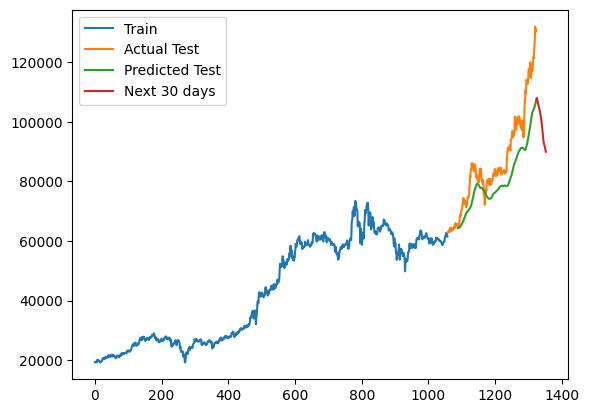

In [44]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# (Split 9/1)

In [45]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
data = pd.read_csv('FPT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
data.head()

,close
0,19318.330078
1,19491.587891
2,19448.273438
3,19318.330078
4,19383.300781


In [46]:
price = data['close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test
train_size = int(len(price_scaled) * 0.9)
test_size = len(price_scaled) - train_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [47]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
17/17 [==============================] - 2s 46ms/step - loss: 0.0149 - val_loss: 0.0133
Epoch 2/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/100
17/17 [==============================] - 1s 37ms/step - loss: 5.8919e-04 - val_loss: 0.0018
Epoch 4/100
17/17 [==============================] - 1s 44ms/step - loss: 5.2636e-04 - val_loss: 0.0018
Epoch 5/100
17/17 [==============================] - 1s 59ms/step - loss: 5.0116e-04 - val_loss: 0.0019
Epoch 6/100
17/17 [==============================] - 1s 57ms/step - loss: 4.9673e-04 - val_loss: 0.0018
Epoch 7/100
17/17 [==============================] - 1s 62ms/step - loss: 4.8101e-04 - val_loss: 0.0022
Epoch 8/100
17/17 [==============================] - 1s 43ms/step - loss: 4.6942e-04 - val_loss: 0.0022
Epoch 9/100
17/17 [==============================] - 1s 34ms/step - loss: 4.9736e-04 - val_loss: 0.0016
Epoch 10/100
17/17 [==============================] - 1s 34ms/step - los

In [48]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

4/4 [==============================] - 0s 6ms/step


In [49]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 24ms/step
[[104787.26 ]
 [105247.33 ]
 [105527.92 ]
 [105520.14 ]
 [105188.23 ]
 [104706.17 ]
 [104178.77 ]
 [103724.734]
 [103291.39 ]
 [102834.07 ]
 [102336.27 ]
 [101806.03 ]
 [101252.42 ]
 [100660.59 ]
 [100002.61 ]
 [ 99280.234]
 [ 98498.016]
 [ 97653.82 ]
 [ 96720.79 ]
 [ 95681.76 ]
 [ 94533.12 ]
 [ 93359.33 ]
 [ 92305.625]
 [ 91493.2  ]
 [ 90949.164]
 [ 90492.56 ]
 [ 90051.47 ]
 [ 89540.96 ]
 [ 89021.92 ]
 [ 88499.59 ]]


In [50]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MLSE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_msle = mean_squared_log_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 15027.208269673245
MAPE trên tập test là: 12.974973016932656 %
MSLE trên tập test là: 0.02246248527161992


In [51]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['close']]
test_data_df = data[train_size:][['close']]

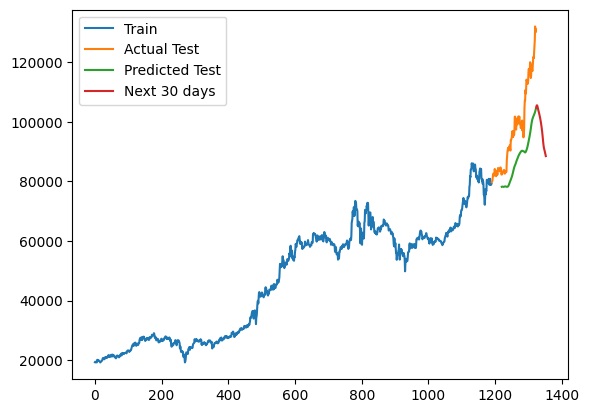

In [52]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()